Notebook Linear Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Lineair Regression toepassen op de data: target is beter doen dan 30% nauwkeurigheid die in de meeste uitwerkingen zit...

==> Resultaat: r² = 91,5%  --- yes, we did it....


Extra:
- er wordt logging voorzien voor en na de belangrijke stappen (zie LinReg_logging.log). Hiermee kunnen de stappen en de resultaten opgevolgd worden
- we hebben een aantal herbruikbare code-blokken in een functie gestoken
- een aparta class gemaakt voor BinaryValueEncoders

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/mirichoi0218/insurance/data


Metadata :
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- data summarizen via summarytools 
- missing en duplicated data oplossen 
- incorrect types controleren
- numerische waarde standardizeren
- categorische varaiabelen processen
- feature engineering
- linear Regression toepassen (ook Ridge en Lasso)




In [345]:
# import van de diverse modules

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance

from sklearn.metrics import classification_report
from sklearn.metrics import  confusion_matrix, accuracy_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

import datetime
from colorama import Fore, Back, Style
import sys
import os
import chardet

Extra code snippits die doorheen de notebook gebruikt worden:

save_fig: na generatie van een image kan de image naar file geschreven worden in de images/.. directory. Geef steeds een zinvolle naam

read_JSON: om eenvoudig een JSON in te lezen

log:
- logging functies om doorheen de notebooks de status naar file te kunnen schrijven. 
- de logstatements worden tijdens de uitvoering van de code bewaard in een list. Die kan tussentijds naar het scherm geprint worden of naar een file
log_info_write_to_file: schrijf de loginformatie naar file 
log_info_print_on_screen: print alle loginfo naar het scherm

In [346]:
# enkele extra code snippets gebruikt doorheen de oefening

plot_graphs = True

# schrijf een visual naar file
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# functies om te loggen naar file
# Lezen van de JSON-file
log_info_lijst = []

def read_JSON(file_path_read):
    with open(file_path_read, 'r') as file:
        files_from_json = json.load(file)
    return files_from_json

def log(log_code="INFO", boodschap="euh geen boodschap????"):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Style.RESET_ALL}{formatted_date} : {log_code} : {boodschap}"
    log_info_lijst.append(log_message)
    print(log_message)
    return

def log_info(boodschap):
    log("Info",boodschap)


def log_info_write_to_file(filename):
    with open(filename, 'w') as file:
        for string in log_info_lijst:
            file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
    return

def log_info_print_on_screen():
    for boodschap in log_info_lijst:
        print(boodschap)    
    return







In [347]:
# maak een boxplot van een kolommen
# df_num_col is een list van de kolomnamen die geplot worden

def plot_boxplot(df, df_num_col, filenaam):
    # boxplot van de numerische waarden
    sns.set_theme(style="whitegrid", palette="bright")
    plt.figure(figsize=(15, 15)) 
    for i, col in enumerate(df_num_col):
        plt.subplot(len(df_num_col), 2, 2 * i + 1)
        sns.boxplot(x=df[col], orient='h', linewidth=1.5)
        plt.title(f"Boxplot of {col}", fontsize=12, fontweight="bold")
        plt.xlabel(col, fontsize=10)

        plt.subplot(len(df_num_col), 2, 2 * i + 2)
        sns.histplot(df[col], kde=True,  linewidth=1)
        plt.title(f"Distribution Plot of {col}", fontsize=12, fontweight="bold")
        plt.xlabel(col, fontsize=10)
        plt.ylabel("Density", fontsize=10)

    plt.tight_layout()
    save_fig(filenaam)
    plt.show()

In [348]:
from sklearn.ensemble import IsolationForest


# functie om het percentage outliers te berkenen voor een set van kolommen in een dataframe
def bereken_percentage_aantal_outliers(df , columns_to_use):
    # Initialiseren van het Isolation Forest model
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

    # Fit het model
    iso_forest.fit(df[columns_to_use])
    # Voorspellingen
    # Het geeft -1 voor outliers en 1 voor inliers
    labels = iso_forest.predict(df[columns_to_use])
    # Toevoegen van de labels aan het DataFrame om outliers te identificeren
    df['outlier'] = labels
    outliers = df[df['outlier'] == -1]
    aantal_outliers = df['outlier'].value_counts()
    print(aantal_outliers)
    percentage_aantal_outliers = (len(outliers) / len(df)) * 100
    return percentage_aantal_outliers


# functie om outliers in een kolom te cappen op een percentiel waarde
def cap_values(df, column, lower_percentile=25, upper_percentile=75):
    # voeg code toe om beter de outliers te verwijderen
    log("Info", f"Capping values voor kolom {column} naar lower percentiel {lower_percentile} - upper percentiel {upper_percentile}")
    q1, q3 = np.percentile(df[column], [lower_percentile, upper_percentile])  # Calculate the 25th (Q1) and 75th (Q3) percentiles
    iqr = q3 - q1  # Calculate the interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower whisker (Q1 - 1.5 * IQR)
    upper_bound = q3 + 1.5 * iqr  # Calculate upper whisker (Q3 + 1.5 * IQR)

    # lower_bound = df[column].quantile(lower_percentile)
    # upper_bound = df[column].quantile(upper_percentile)
    
    # Waarden cappen met behulp van de numpy.where functie
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])    
    return df



from sklearn.base import TransformerMixin, BaseEstimator

# hulp klasse om categorische waarden met twee mogelijke waarde naar 0 en 1 om te zetten
class BinaryValueEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, string_zero="nul", string_one="een"):
        # Je kunt hier extra initialisatie toevoegen indien nodig
        self.string_zero = string_zero
        self.string_one = string_one
     

    def fit(self, X, y=None):
        # Er is geen fitting nodig voor deze eenvoudige codering
        return self

    def transform(self, X):
        # X wordt aangenomen een pandas DataFrame te zijn
        log("Info", f"BinaryValueEncoder transform opgeroepen voor One_value {self.string_one} en Zero_value {self.string_zero}")
        X = X.copy()  # Kopieer de DataFrame om wijzigingen te voorkomen in het origineel
        X = X.applymap(lambda x: 1 if x == self.string_zero else 0)
        return X


def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out


    if not hasattr(BinaryValueEncoder, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = BinaryValueEncoder.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        BinaryValueEncoder.__init__ = __init__
        BinaryValueEncoder.get_feature_names_out = get_feature_names_out


monkey_patch_get_signature_names_out()


Monkey-patching FunctionTransformer.get_feature_names_out()


In [349]:
# data bestand inlezen

insurance_data_filename = 'data/insurance.csv'
df = pd.read_csv(insurance_data_filename)
log_info(f"File {insurance_data_filename}")

# behoudt een copie van de orginele data
df_original = df.copy()

10/02/2025 12:00:38 : Info : File data/insurance.csv


In [350]:
# enkele eenvoudige controles

log_info(f"df.info : \n{df.info()}")
log_info(f"df.describe : \n{df.describe()}")

# geen nulwaarden 

from summarytools import dfSummary
dfSummary(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
10/02/2025 12:00:38 : Info : df.info : 
None
10/02/2025 12:00:38 : Info : df.describe : 
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 39.2 (14.0)min < med < max:18.0 < 39.0 < 64.0IQR (CV) : 24.0 (2.8),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACXUlEQVR4nO3cT4riQBiH4a/GVuMfEkTQnRcYmIXLHGIOO0fohSfwBu4EkYjpDsaYWQzSMwOjnTgxv+j7bJtKS/FamsKKy/PcABVf6n4BwO9eLv3ROdczs07Jax/yPH8vORZP6p9BOud64/H4u+/7ozIX3u12W+fcD6JEEZdWyI7v+6MwDN+DIEiKXDSKIm+xWIw2m03HzAgSn3bxI9vMLAiCZDKZvJW4dq/EGDw5bmoghSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAhhSAh5eovxlE9DtN9IMiacZjuT5UFmWVZ28x851yZ4Y1719+wyvnD4XAShuGOw3QVBRnHcTtN02+z2azVarUKTbJZ8971t6xyaZp6WZZ97Xa7rxymqyjIw+Hw4nlefz6fJ9PpdFtkbEPf9aWPDK9Wq9Fyuewfj8dWVS+uSSr9DjkYDO5+hLbOG4QyR4a3221tK5zizdRD3dRwg/B5qnP1UEEaT9soQnKuHi1IM+NpG0WozdVDBvlMbthe80+nU7uG/2t24funZJB1TXLT3LK9dt5uSpLk1cwKrZBVbuvJBVnXJDfRLdtrt2w3VbmtJxdkXZNs1tyVucz22v/YbqpiW08uyLN7TzIrswbZIO+tzpUZHwjyL3V9/OEXfqALKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKVcfFBBFkVf0ovv93jMzi+PYW6/XfcYy9uxaTz8BiY60rVdc/9gAAAAASUVORK5CYII="">",0(0.0%)
2,sex[object],1. male2. female,676 (50.5%)662 (49.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bwYnDMBRF0a8gwmQjYQwuxkVMsSlC3RhjLZKQjWYxDcR/8YTIPRV8zMWQ4BdaawYoBDO7mdm19yEDerfWnr2PGEmc5/k3pTT1PmQ0tdY9hHAnuM/FlNK0rusz5/zqfcwojuP4KaVM27ZdzYzYPhTNzHLOr2VZHr2PGcyt9wGjufQ+AN+D2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmWj2/zFg70NGwvPyibXWvZQyGR8DnlJr3c3s3fuOkTB48WPwclJgygcV3mw+vNUcmPI5MOPzYcp3EjM+P6Z8Pvxyd+BPXcgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggw5TvJJ6VH1M+B2Z8PgxefBi8OPwBCltq31np+ZoAAAAASUVORK5CYII="">",0(0.0%)
3,bmi[float64],Mean (sd) : 30.7 (6.1)min < med < max:16.0 < 30.4 < 53.1IQR (CV) : 8.4 (5.0),548 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACV0lEQVR4nO3bwYraQBzH8f/UdYkKEbHozRco9ODRh+jD9hEq+AS+gTchSMTUYIzpoQvtFnaXjJPmt9nv5z6YwxfDZP7jqqoyQMWnth8A+NtD2w8QmnNuYGaPnssvVVWdQz4P6ulUkM65wXQ6/RbH8cRn/fF4PDjnvhNlezoVpJk9xnE8Wa1W5/F4nNdZmKZptNlsJkmSPJoZQbaka0Gamdl4PM5ns9lPj6WD4A+DWtjUQApBQkonX9m+yrLsm1nsnPNZzg49AIJ8kmVZvyiKr4vFotfr9WptiMzYoYdCkE8ul8tDFEXD5XKZz+fzQ5217NDDIch/jEYjdugtYlMDKQQJKQQJKQQJKQQJKQQJKZKffe6YaYxvt1s/9PPg/5EL8p6ZxqIoorIsv+R5/sPMfL4lomVyQdodM4273W6y3W6H1+u119TDoVmKQZqZ30zj4XDgtOSdY1MDKQQJKQQJKQQJKbKbmveGafMwCDIAps3DIcgAmDYPhyADYtr8fmxqIIUgIYUgIYUgIYUgIYUgIYUgIYUgIYUgIaWxkxouasFHI0FyUQu+mvqH5KIWvDQ6XMFFLdTFpgZSCBJSmIcUwPWHPwiyZVx/eI4gW8b1h+cIUgTXH35jUwMpBAkpBAkpBAkpBAkpBAkpBAkpBAkpr34YZ+pbX9fOwV8MkqlvfV08B3/tH5Kpb3FdPAd/8yybqW99vufgZVnGJva6Z7jig1J93RPkB3Xv6369Xs+SJPnsnDv6/PxLIb8ZZJqmUd1fO51OkZlZlmXRfr8fslZ3rY/z+dzYv+svSFme8aj5M/MAAAAASUVORK5CYII="">",0(0.0%)
4,children[int64],1. 02. 13. 24. 35. 46. 5,574 (42.9%)324 (24.2%)240 (17.9%)157 (11.7%)25 (1.9%)18 (1.3%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACw0lEQVR4nO3dQU7bUBiF0T9RRJuJowiJZbCALKKL7SKygOwDRXjQUCbpoJTSDoCBfZ9lnzNj9pA+vciRr7K6Xq8FCevWB2A5xEaM2IgRGzGrqtpW1U3rg0zA8/V6vbQ+xJxtbm9vv3Vdt299kNb6vj+vVqvvghvPpuu6/eFwuOx2u6fWh2nl8fHx6/F43D88PNxUldhGsqmq2u12T3d3dz9aH6axbesDzJ0HBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZlP1+xWb1gdpaen/f8qm7/vz8Xjc18Jfsen7/lxVz63PMWdeC//La+EjWxkpkzLlm81NMzOTHbwYoMzPJAcvBijzNOXBy6KfjufIl7rEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiJnkumpq52EYk11XWTvNjw0CMdZVxLS42dxYCxVfV1lNLVd0XWU1tWwt1lWTeuolx5e6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IiJrqusppYtvq6ymlouGwRirKuIGfJmc2PxrsHWVVZTfGSQdZXVFJ8x

In [351]:
# drie categorische features: smoking, region en sex
# vier numerische features waaronder de target variabele "charges"
# maak de datasets aan 

df_cat_col = ['smoker','region','sex']
df_num_col = ['age', 'bmi','children']
df_label_col = ['charges']

# zijn er nominaal categorische variabelen en één ordinal categorische waarden?
df_cat_nom_col = ['smoker','region']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]

In [352]:
# korte analyze van de categorische variabelen
df_cat.value_counts()

# check op nullen
nul_waarden = df.isnull().sum()
log_info(f"Check op nulwaarden \n{nul_waarden}")
# geen nullen

#check op duplicates
duplicate_waarden = df.duplicated().sum()
log_info(f"Check op duplicates \n{duplicate_waarden}")
#  oeps er is er één
# drop it

df.drop_duplicates(inplace=True)
df_original = df.copy()
duplicate_waarden = df.duplicated().sum()
log_info(f"Check op duplicates na drop \n{duplicate_waarden}")


10/02/2025 12:00:38 : Info : Check op nulwaarden 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
10/02/2025 12:00:38 : Info : Check op duplicates 
1
10/02/2025 12:00:38 : Info : Check op duplicates na drop 
0


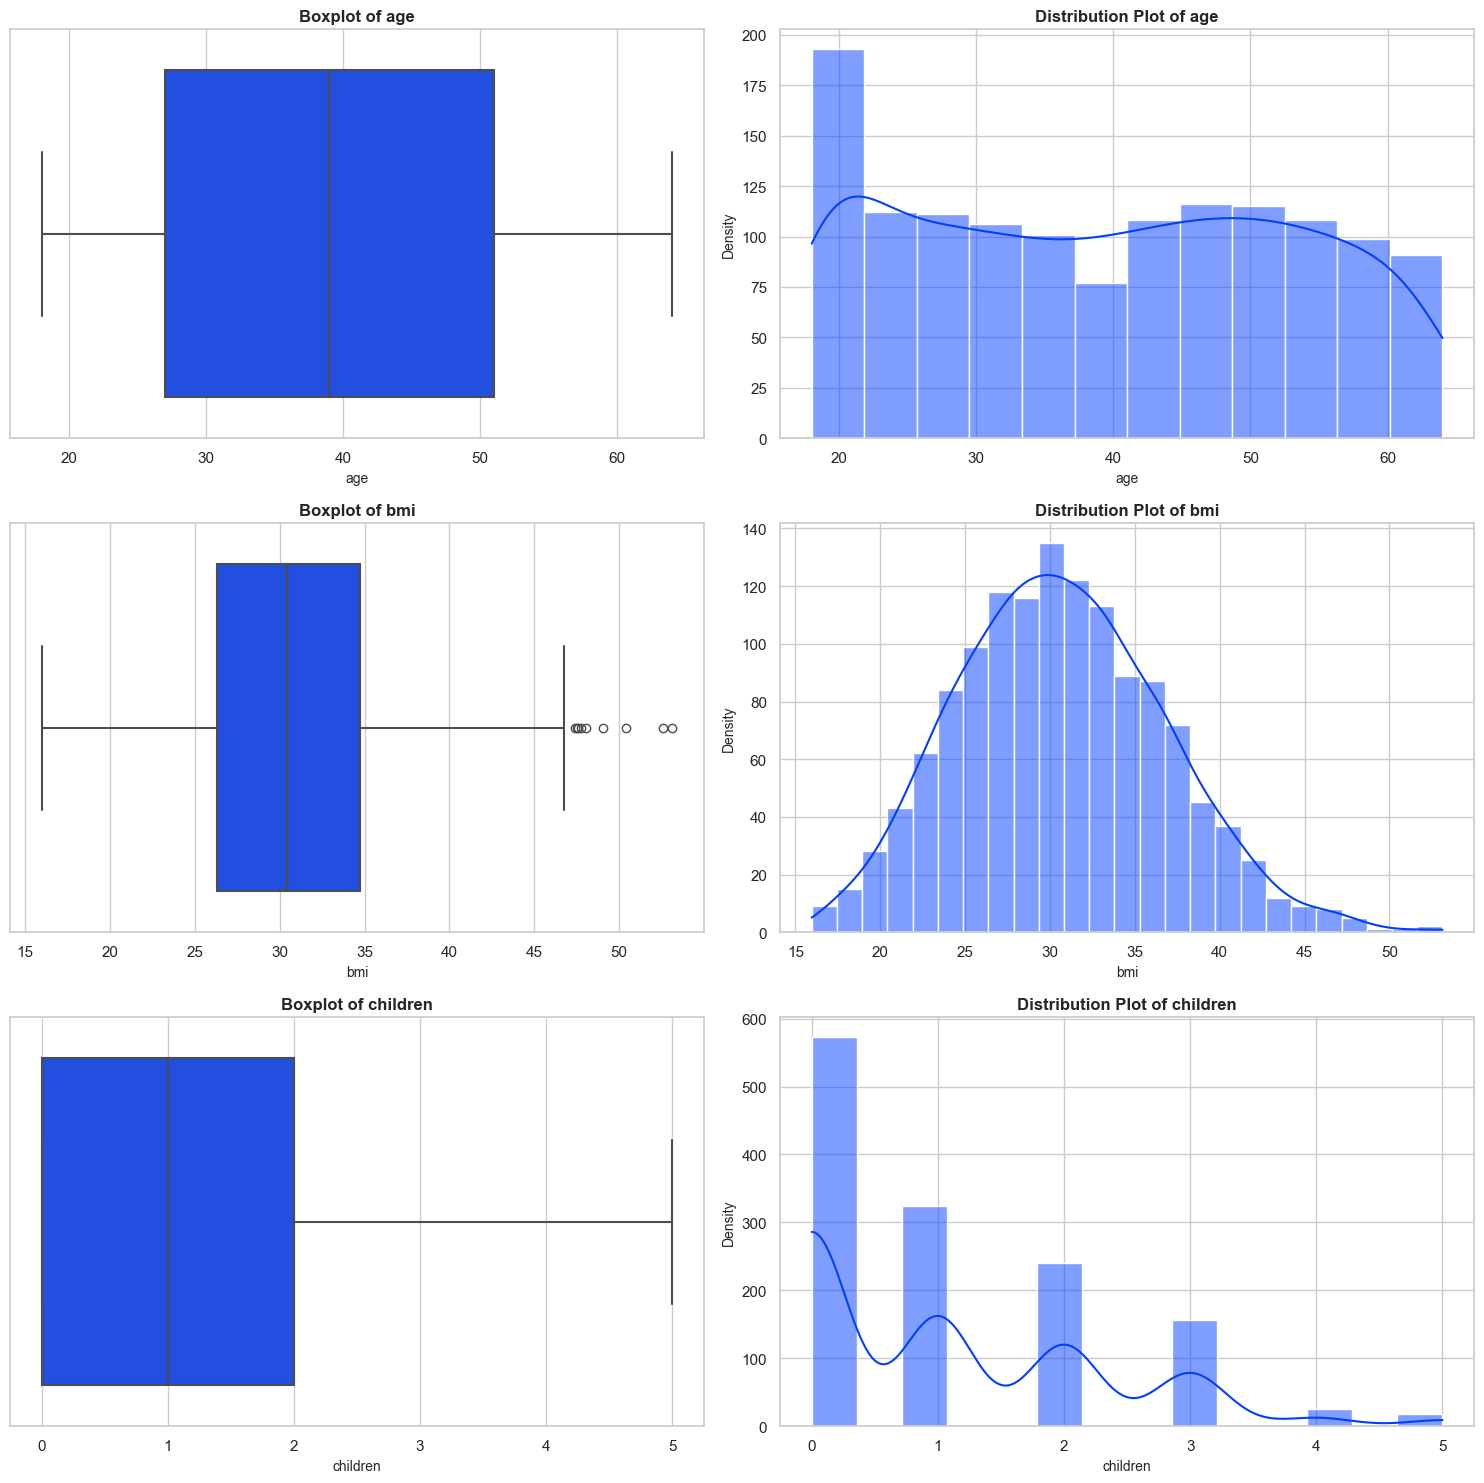

In [353]:
plot_boxplot(df, df_num_col,"Boxplot en histogram van de numerische waarden")

C:\Users\geert\AppData\Local\Temp\ipykernel_12792\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')
C:\Users\geert\AppData\Local\Temp\ipykernel_12792\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')
C:\Users\geert\AppData\Local\Temp\ipykernel_12792\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')


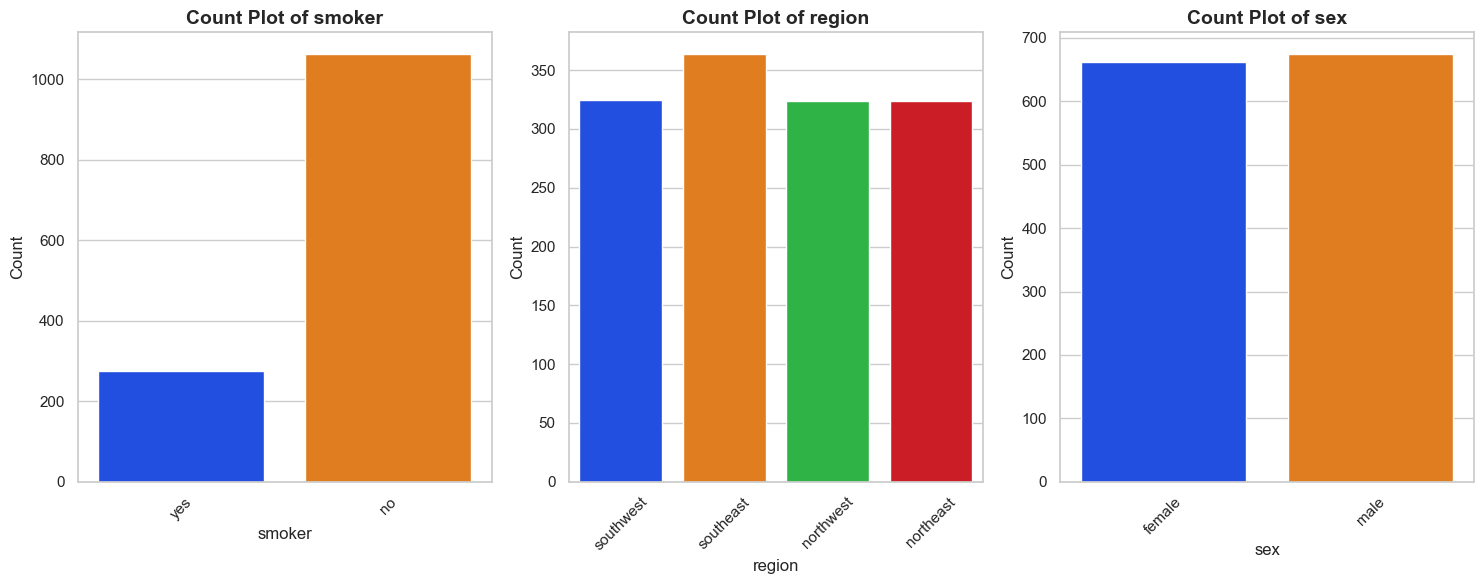

10/02/2025 12:00:42 : Info : Check van categorische features


In [354]:
sns.set_theme(style="whitegrid", palette="bright")
plt.figure(figsize=(15, len(df_cat_col) * 2))  

for i, col in enumerate(df_cat_col):
    plt.subplot(1, len(df_cat_col), i + 1)
    sns.countplot(x=col, data=df, palette='bright')
    plt.title(f"Count Plot of {col}", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
save_fig("Categorische features countplot")
plt.show()
log_info("Check van categorische features")

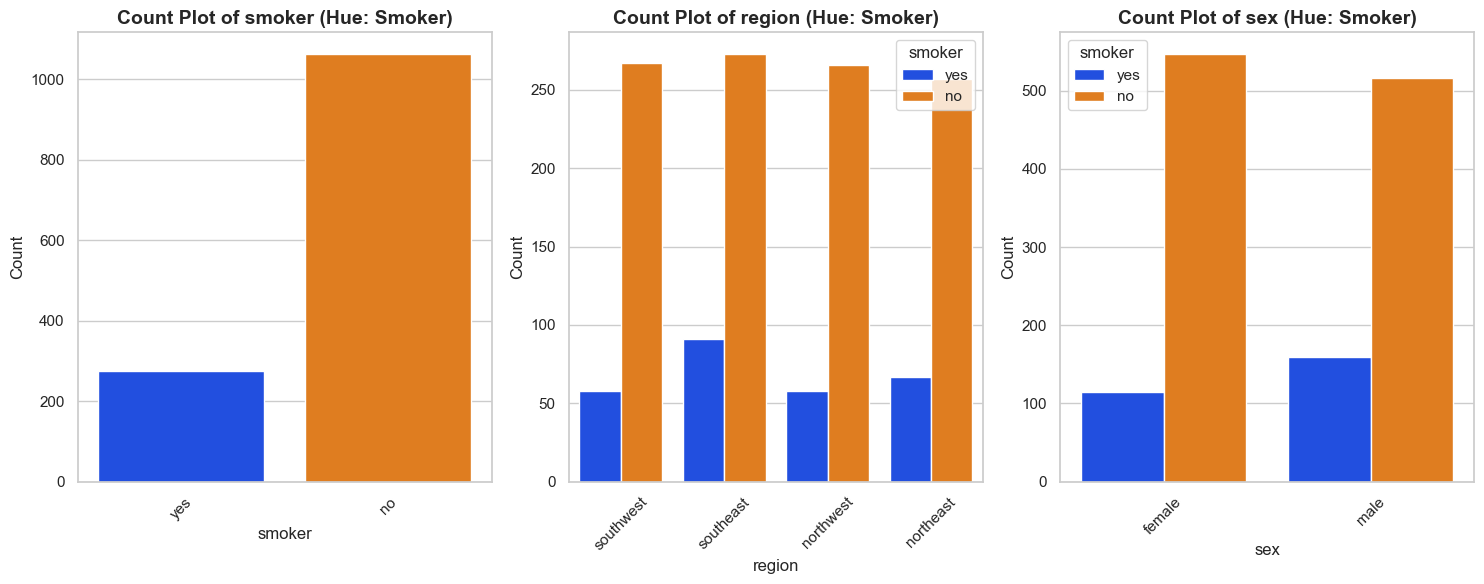

In [355]:
sns.set_theme(style="whitegrid", palette="bright")
plt.figure(figsize=(15, len(df_cat_col) * 2))  

for i, col in enumerate(df_cat_col):
    plt.subplot(1, len(df_cat_col), i + 1)
    sns.countplot(x=col, data=df, palette='bright', hue='smoker')
    plt.title(f"Count Plot of {col} (Hue: Smoker)", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
save_fig("Categorische variabelen tov smoker")
plt.show()

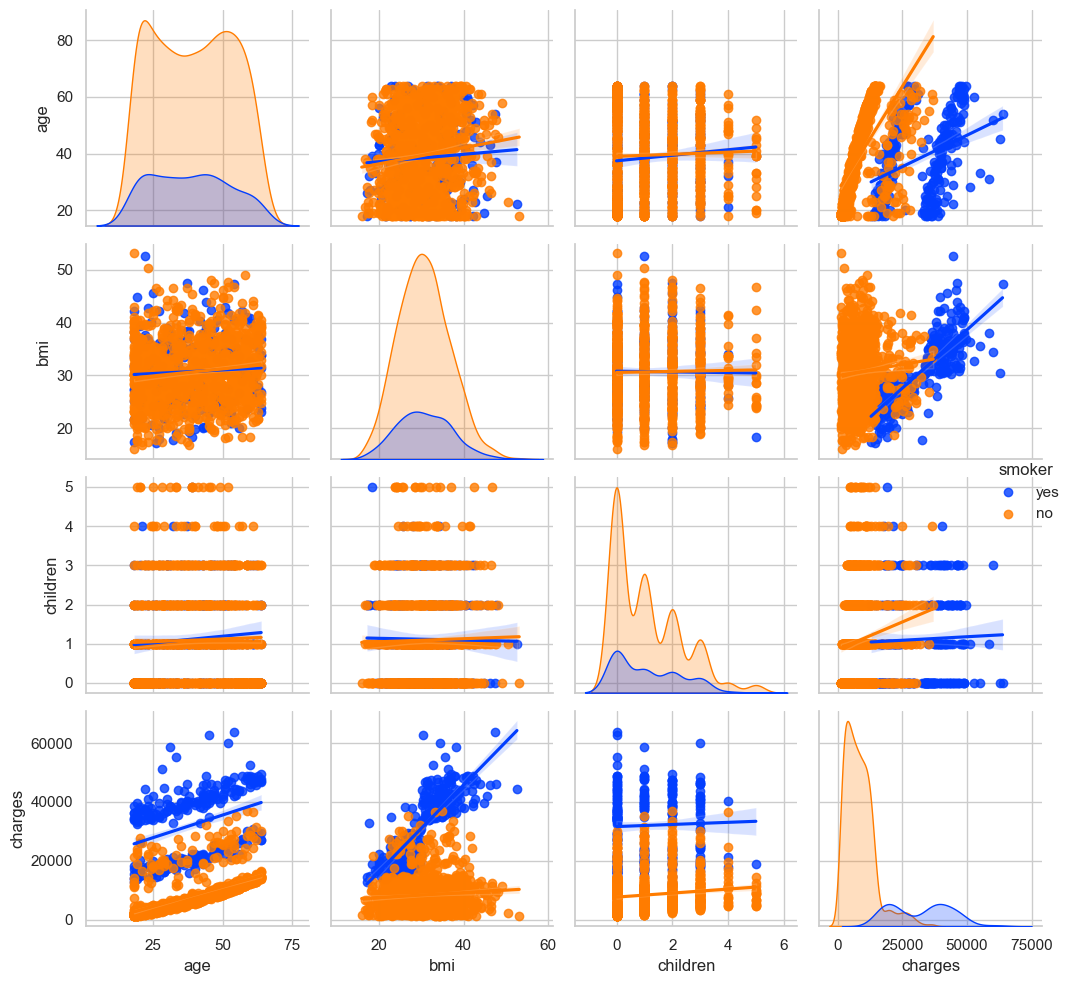

In [356]:
sns.pairplot(df, hue='smoker',  kind='reg')
plt.tight_layout()
save_fig("Numerische features onderlinge scatter")
plt.show()

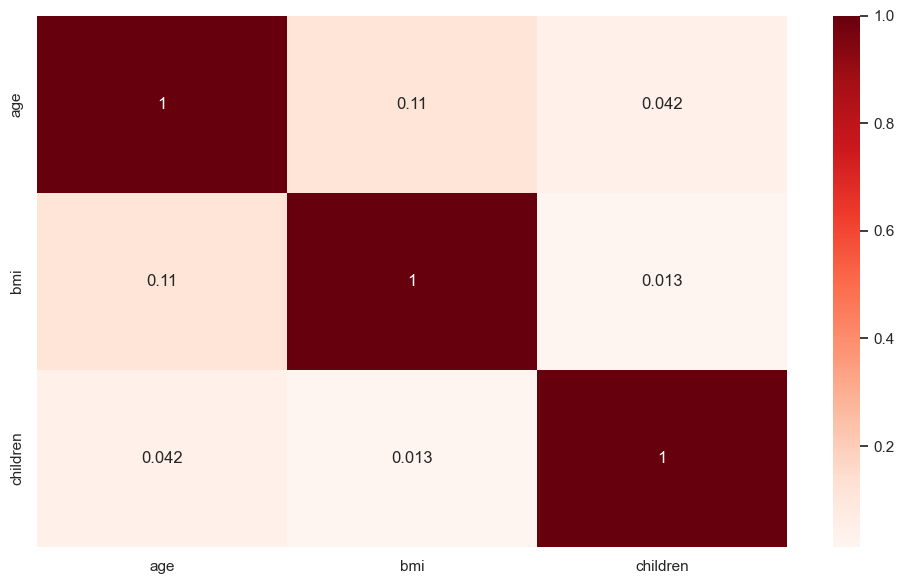

In [357]:
# print de correlation nog af tussen de numerische waarden

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="bright")
sns.heatmap(df[df_num_col].corr(), annot=True, cmap='Reds')
save_fig("Numerische features correlatie")
plt.show()

In [358]:



# functie om een linear fit te doen op X,y 


outlier
 1    1074
-1     263
Name: count, dtype: int64
19.670905011219148
10/02/2025 12:00:50 : Info : Check op de outliers in kolom [bmi, charges] : 19.670905011219148
10/02/2025 12:00:50 : Info : Capping values voor kolom bmi naar lower percentiel 25 - upper percentiel 75
outlier
 1    1030
-1     307
Name: count, dtype: int64
22.961854899027674


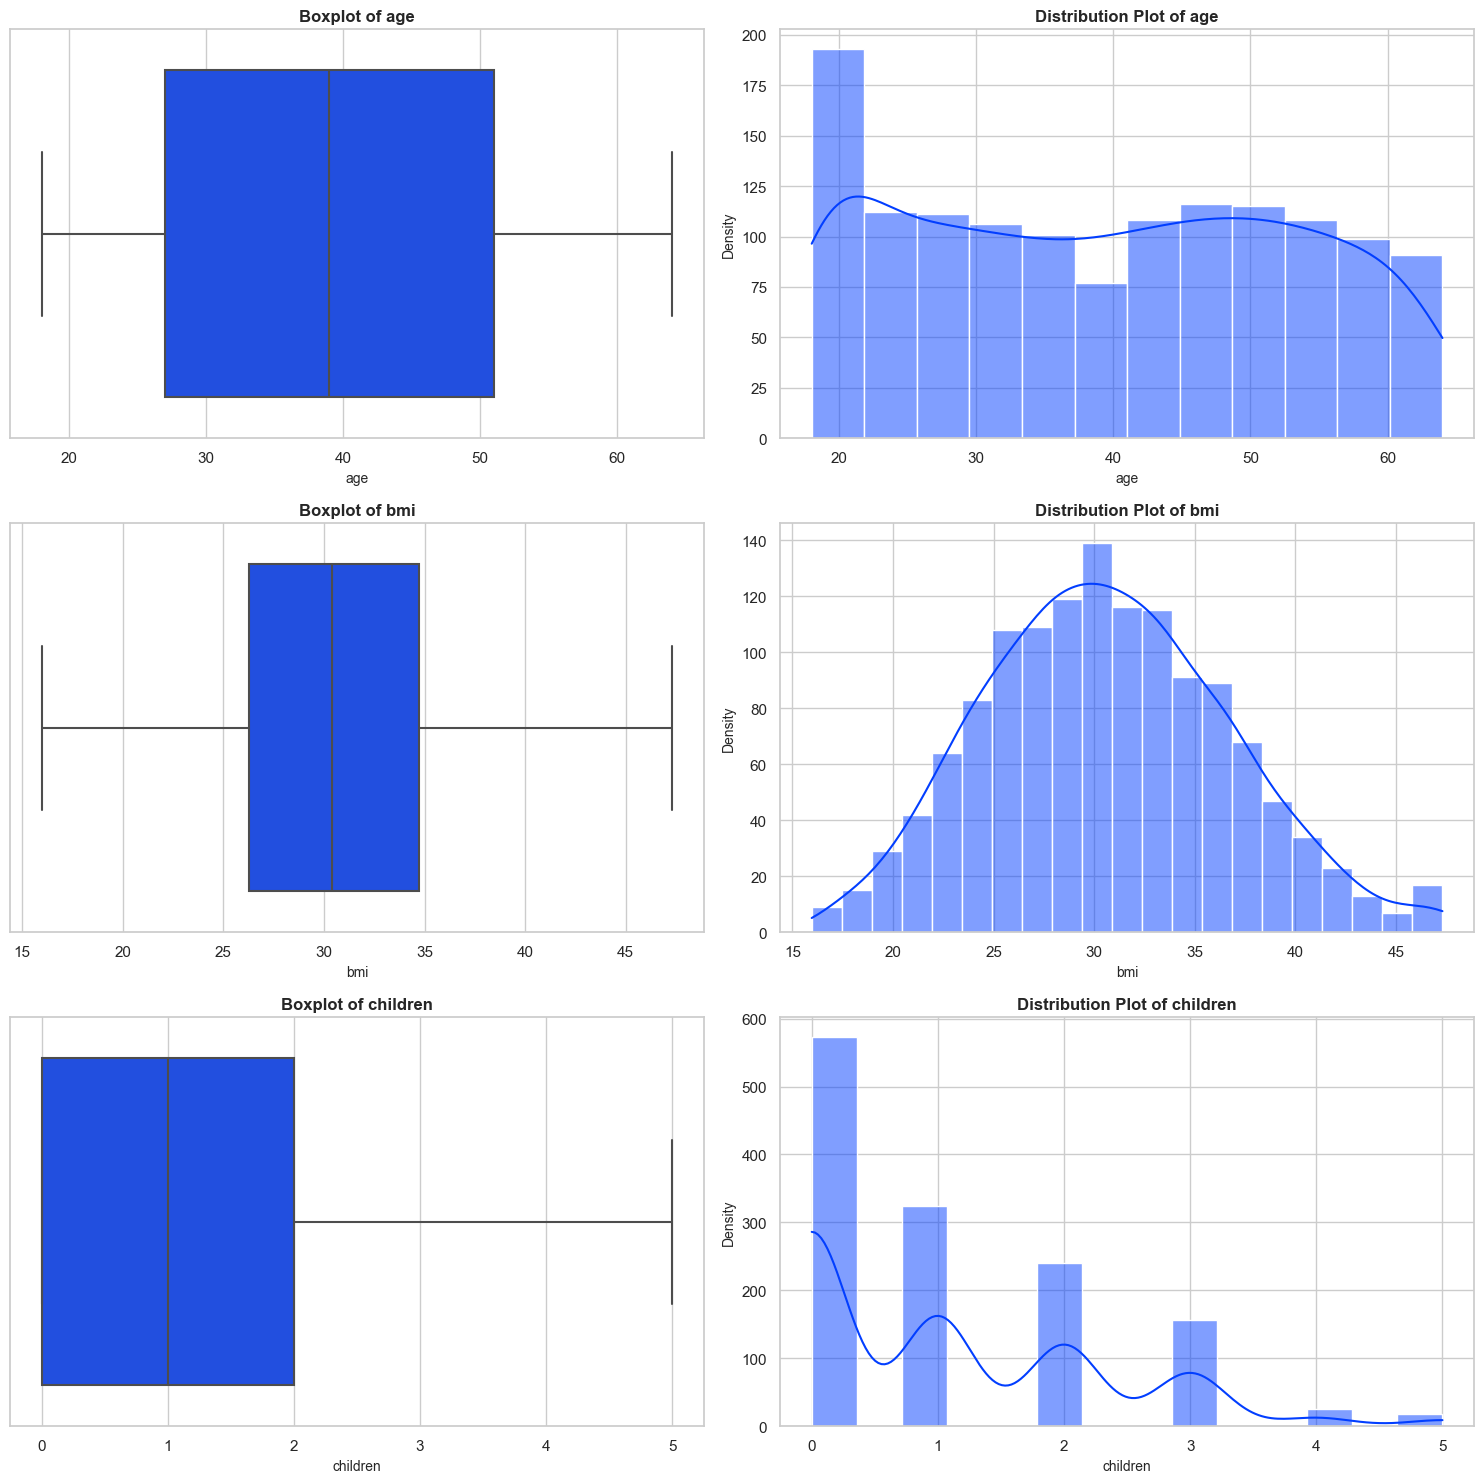

10/02/2025 12:00:53 : Info : Check op de outliers in kolom [bmi, charges] na capping op kolom [bmi]  : 22.961854899027674
10/02/2025 12:00:53 : Info : Capping wordt niet toegepast op de dataset


In [359]:
# Initialiseren van het Isolation Forest model



percentage_aantal_outliers = bereken_percentage_aantal_outliers(df, ['bmi'])
print(percentage_aantal_outliers)
log_info(f"Check op de outliers in kolom [bmi, charges] : {percentage_aantal_outliers}")

df = cap_values(df,'bmi')
# df = cap_values(df,'charges')
percentage_aantal_outliers = bereken_percentage_aantal_outliers(df, ['bmi'])
print(percentage_aantal_outliers)
plot_boxplot(df, df_num_col,"Boxplot en histogram na removing van de outliers")
log_info(f"Check op de outliers in kolom [bmi, charges] na capping op kolom [bmi]  : {percentage_aantal_outliers}")
log_info("Capping wordt niet toegepast op de dataset")

#df_original = df.copy()



10/02/2025 12:00:53 : Info : BinaryValueEncoder transform opgeroepen voor One_value female en Zero_value male
10/02/2025 12:00:53 : Info : BinaryValueEncoder transform opgeroepen voor One_value no en Zero_value yes


C:\Users\geert\AppData\Local\Temp\ipykernel_12792\4218665540.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: 1 if x == self.string_zero else 0)


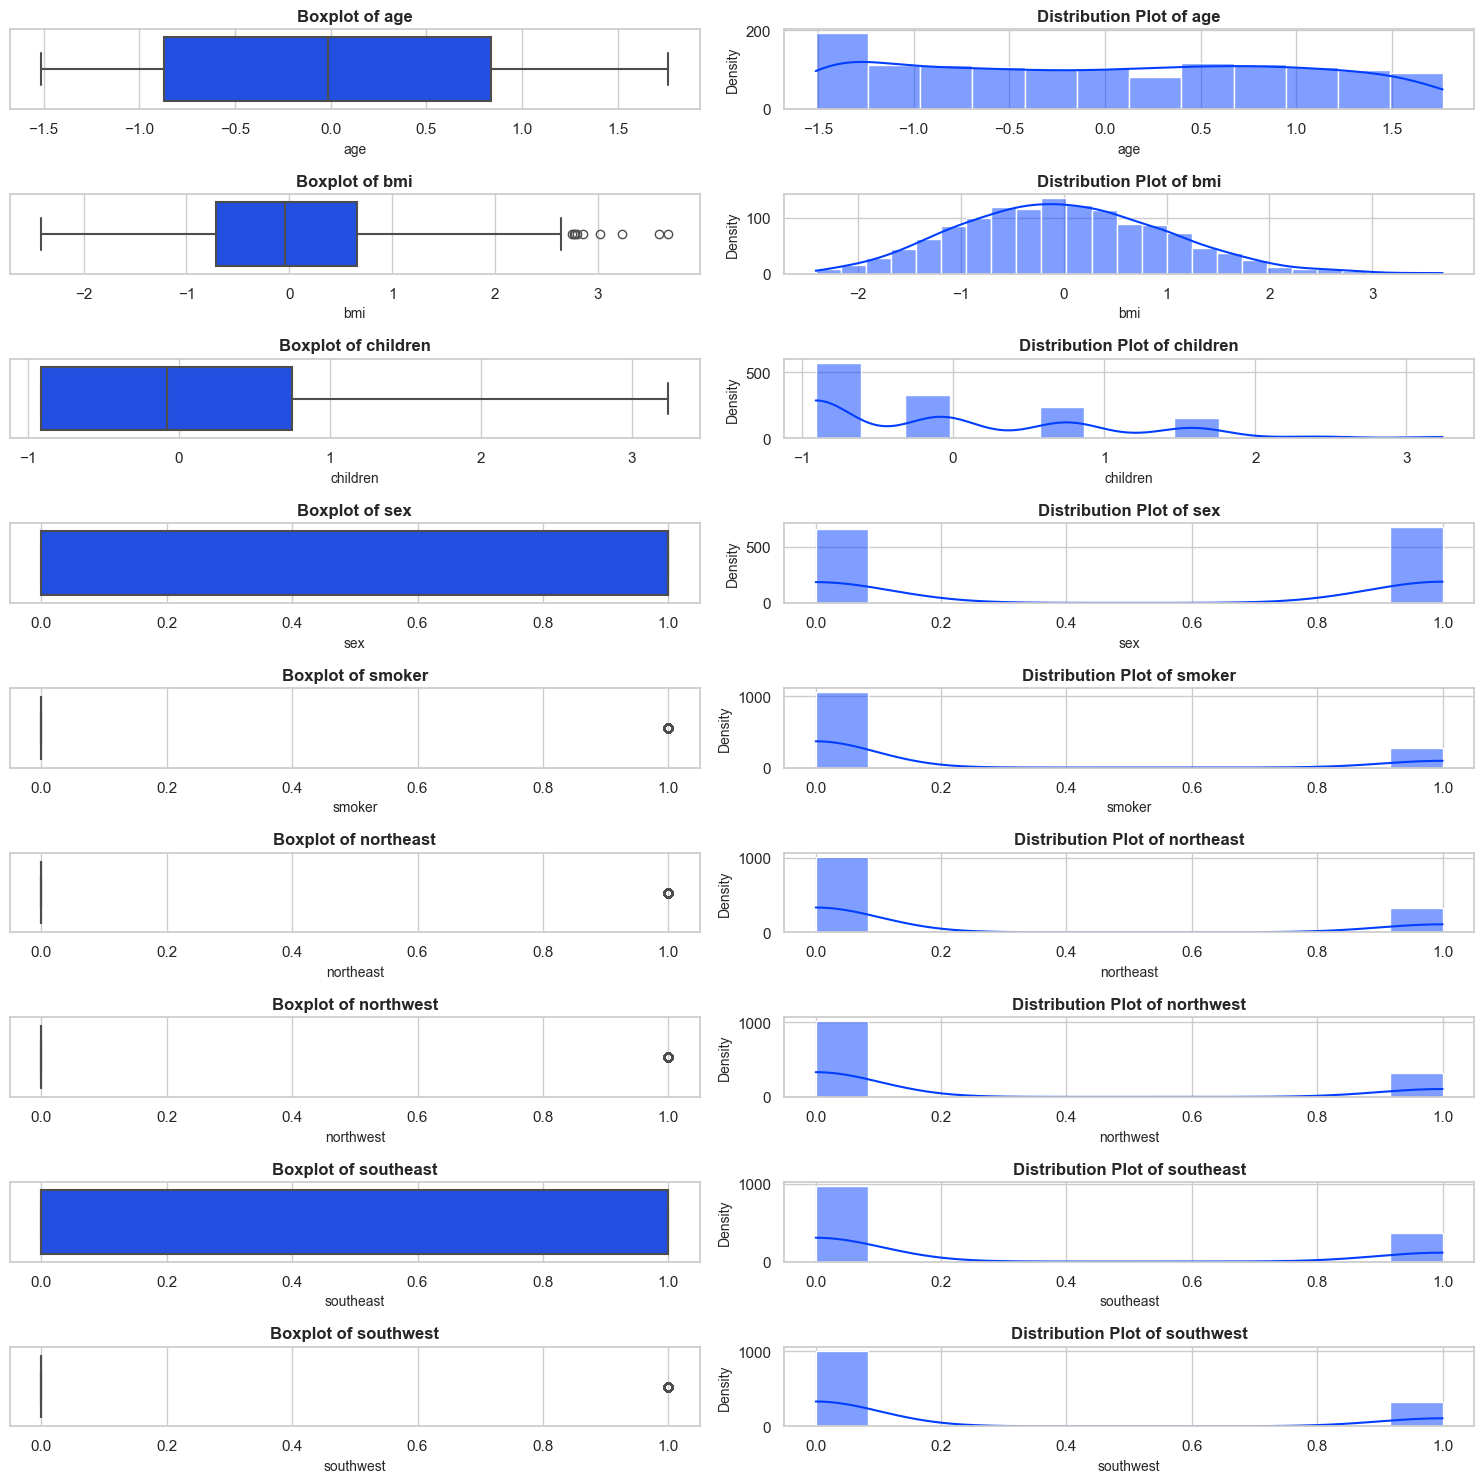

In [360]:
# Feature preparation
# standard scaler op de numerische waarden, min-max scaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer



num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

#set_matplotlib_closeV_encoder = BinaryValueEncoder("male","female")
#set_matplotlib_smoking_encoder = BinaryValueEncoder("yes","no")
# bv_encoder = PredefinedBinaryCategoricalEncoder(positive_class='female')

male_female_transformer = Pipeline(steps=[
    ('male_female_encoder', BinaryValueEncoder("male","female"))
])

smoking_transformer = Pipeline(steps=[
    ('smoking_encoder', BinaryValueEncoder("yes","no"))
])

regio_transformer = Pipeline(steps=[
    ('regio', OneHotEncoder(handle_unknown="ignore"))
])


preprocessing = ColumnTransformer([
    ("num", num_pipeline, df_num_col),
    ("male_female", male_female_transformer, ['sex']), 
    ("smoker", smoking_transformer, ['smoker']), 
    ("regio", regio_transformer, ['region'])],
     remainder='passthrough')

df_features = df_original.drop(['charges'], axis= 1)
np_prepared =  preprocessing.fit_transform(df_features)

# really hacking !!! get_feature_names werkt nog niet correct !!!
df_prepared_col = ['age', 'bmi','children','sex','smoker','northeast','northwest','southeast','southwest']

df_prepared = pd.DataFrame(
    np_prepared,
    #columns=preprocessing.get_feature_names_out(),
    #columns = [name.split('__')[-1] for name in preprocessing.get_feature_names_out()],
    columns = df_prepared_col,
    index=df_original.index)

df_prepared.head()

plot_boxplot(df_prepared,df_prepared_col,"Boxplot van numerische waarden na standard scaling")




In [361]:
# data set opsplitsen
# voorlopig via een aanvoudig train_test_split, nadien gaan we dit doen op het histogram van de charges


# opdelen train - test - set

# gebruik maken van stratefy en op basis van de categorisatie van de charges
# om ervoor te zorgen dat in de train - test split zelfde verhoudingen voorkomen

df_prepared["charges_cat"] = pd.cut(df["charges"], bins=[0, 20000,30000, np.inf], labels=[1, 2, 3])
log_info("extra feature engineering: charges omzetten naar categories : bins=[0, 20000,30000, np.inf")
df.head()

X = df_prepared
y = df_original['charges']
#y = df['charges']

print(X.head())
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_prepared["charges_cat"] , test_size=0.4, random_state=42)
log_info("Train_test_split met stratefy = charges_cat")


10/02/2025 12:00:58 : Info : extra feature engineering: charges omzetten naar categories : bins=[0, 20000,30000, np.inf
        age       bmi  children  sex  smoker  northeast  northwest  southeast  \
0 -1.440418 -0.453160 -0.909234  0.0     1.0        0.0        0.0        0.0   
1 -1.511647  0.509422 -0.079442  1.0     0.0        0.0        0.0        1.0   
2 -0.799350  0.383155  1.580143  1.0     0.0        0.0        0.0        1.0   
3 -0.443201 -1.305052 -0.909234  1.0     0.0        0.0        1.0        0.0   
4 -0.514431 -0.292456 -0.909234  1.0     0.0        0.0        1.0        0.0   

   southwest charges_cat  
0        1.0           1  
1        0.0           1  
2        0.0           1  
3        0.0           2  
4        0.0           1  
0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64
10/02/2025 12:00:58 : Info : Train_test_split met stratefy = charges_cat


Mean Squared Error (MSE): 12652841.906158803
Root Mean Squared Error (RMSE): 3557.0833425938736
R-squared (R²): 0.9157889889132937
We zitten er gemiddeld 23.33% naast met onze voorspellingen.
10/02/2025 12:00:58 : Info : Linear regression met MSE 12652841.91, RMSE 3557.08, R² 0.92, gemiddelde afwijking 23.33%


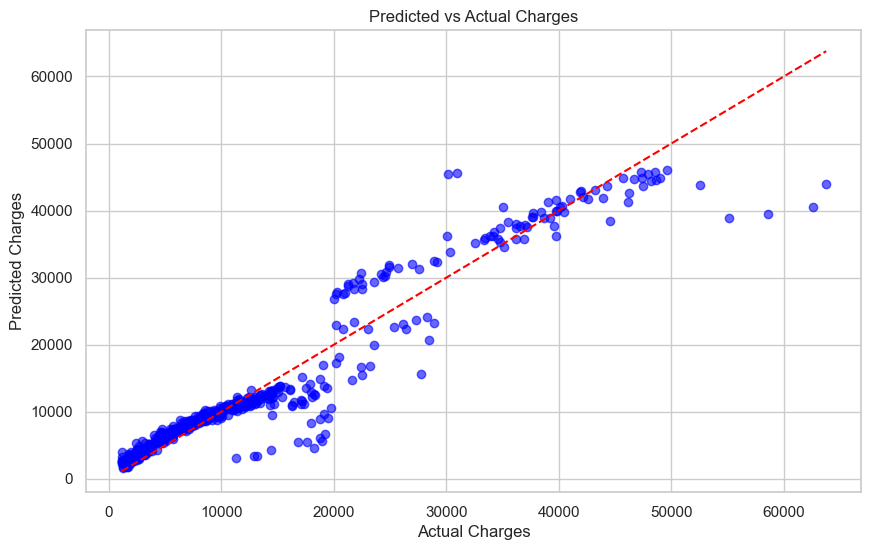

In [362]:
# simpele linear regression 

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

y_pred = linreg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

print(f"We zitten er gemiddeld {mape*100:.2f}% naast met onze voorspellingen.")
log_info(f"Linear regression met MSE {mse:.2f}, RMSE {rmse:.2f}, R² {r2:.2f}, gemiddelde afwijking {mape*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect prediction line
plt.title('Predicted vs Actual Charges')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.show()






Ridge Regression Metrics:
Mean Squared Error (MSE): 12652884.001936559
Root Mean Squared Error (RMSE): 3557.0892597651464
R-squared (R²): 0.9157887087447725
We zitten er gemiddeld 23.33% naast met onze voorspellingen.
10/02/2025 12:00:58 : Info : Rdige regression met MSE 12652884.00, RMSE 3557.09, R² 0.92, gemiddelde afwijking 23.33%


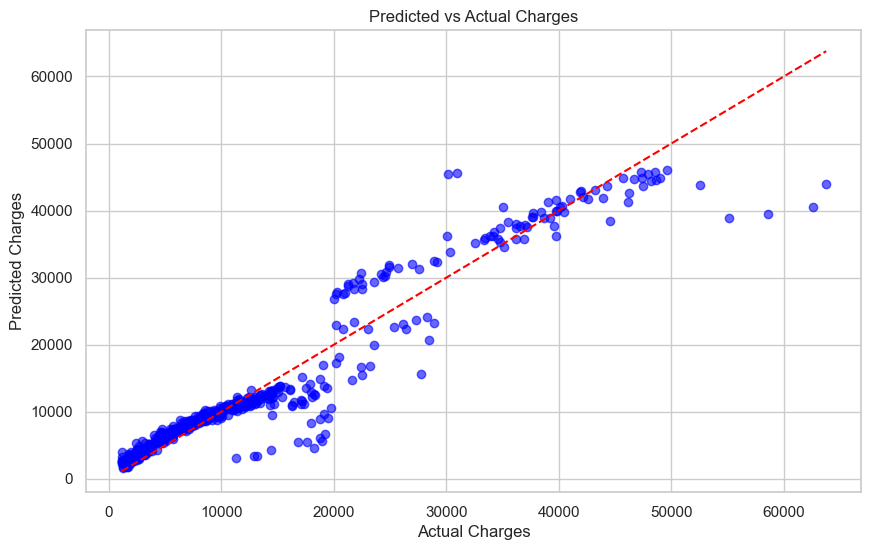

In [363]:
# ridge Regression

ridge = Ridge(alpha=0.01)  
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Evaluate the model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\nRidge Regression Metrics:")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge}")
print(f"R-squared (R²): {r2_ridge}")
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)
print(f"We zitten er gemiddeld {mape_ridge*100:.2f}% naast met onze voorspellingen.")


log_info(f"Rdige regression met MSE {mse_ridge:.2f}, RMSE {rmse_ridge:.2f}, R² {r2_ridge:.2f}, gemiddelde afwijking {mape_ridge*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect prediction line
plt.title('Predicted vs Actual Charges')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.show()


In [ ]:
lasso = Lasso(alpha=0.1)  
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_test, y_pred_lasso)
print(f"We zitten er gemiddeld {mape_lasso*100:.2f}% naast met onze voorspellingen.")

print("Lasso Regression Metrics:")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")
print(f"R-squared (R²): {r2_lasso}")

log_info(f"Lasso regression met MSE {mse_lasso:.2f}, RMSE {rmse_lasso:.2f}, R² {r2_lasso:.2f}, gemiddelde afwijking {mape_lasso*100:.2f}%")


log_info_write_to_file("LinReg_logging.log")

We zitten er gemiddeld 23.37% naast met onze voorspellingen.
Lasso Regression Metrics:
Mean Squared Error (MSE): 12654033.47234584
Root Mean Squared Error (RMSE): 3557.250830676105
R-squared (R²): 0.9157810584424848
10/02/2025 12:06:32 : Info : Lasso regression met MSE 12654033.47, RMSE 3557.25, R² 0.92, gemiddelde afwijking 23.37%
